In [68]:
import os
os.chdir("/home/user/src")
os.listdir()

['model.py',
 'notebooks',
 'aux',
 'train.py',
 'configs',
 '__pycache__',
 'utils.py',
 'main.py',
 'dataset.py']

In [69]:
import torch
import hydra
import omegaconf
import rasterio as rio
import glob

import matplotlib.pyplot as plt
from utils import preprocess_s2, s2toRGB

# settings

In [70]:
checkpoint = "/home/user/results/vit_8x8/2024-09-25_08:18:44/model_checkpoints/checkpoint_100_39000.pt"
configdir = "./configs/vit_8x8.yaml"
data_topdir = "/home/user/datainference"

# init the model and load weights

In [71]:
cfg = omegaconf.OmegaConf.load(configdir)
model = hydra.utils.instantiate(cfg.model)

In [72]:
state_dict = torch.load(checkpoint,map_location=torch.device('cpu'))
model.load_state_dict(state_dict["model_state_dict"])
model.eval()

pass

# load a S2 image

In [73]:
classnames = ["AnnualCrop","HerbaceousVegetation","Industrial",
              "PermanentCrop","River","Forest","Highway",
              "Pasture","Residential","SeaLake"]


samples = {}
for cn in classnames:
    samples[cn] = glob.glob(os.path.join(data_topdir,"**",f"*{cn}*.tif"),recursive=True)

samples

{'AnnualCrop': ['/home/user/datainference/EuroSATallBands_RESTRICTED/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/AnnualCrop/AnnualCrop_1092.tif',
  '/home/user/datainference/EuroSATallBands_RESTRICTED/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/AnnualCrop/AnnualCrop_2869.tif',
  '/home/user/datainference/EuroSATallBands_RESTRICTED/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/AnnualCrop/AnnualCrop_2356.tif',
  '/home/user/datainference/EuroSATallBands_RESTRICTED/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/AnnualCrop/AnnualCrop_2521.tif',
  '/home/user/datainference/EuroSATallBands_RESTRICTED/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/AnnualCrop/AnnualCrop_2413.tif',
  '/home/user/datainference/EuroSATallBands_RESTRICTED/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/AnnualCrop/AnnualCrop_6.tif',
  '/home/user/datainference/EuroSATallBands_RESTRICTED/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/AnnualCrop/AnnualCrop_2207.t

data shape (13, 64, 64)


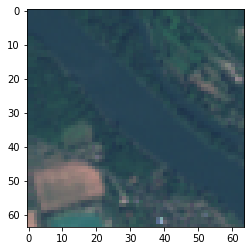

In [74]:
N = 50

with rio.open(samples["River"][N], "r") as src:
    data = preprocess_s2( src.read() )

print("data shape", data.shape)

plt.imshow(s2toRGB(data))
plt.show()

# inference

In [75]:
x = torch.tensor(data,dtype=torch.float32).unsqueeze(0)

In [76]:
cls, feat = model(x)

In [77]:
cls

tensor([[-2.2793, -0.2755,  0.7793, -2.7678,  9.6072, -2.3372,  0.7193, -1.6481,
         -1.7540,  1.8401]], grad_fn=<AddmmBackward0>)

In [78]:
cls.argmax()

tensor(4)

In [79]:
feat.shape

torch.Size([1, 65, 768])

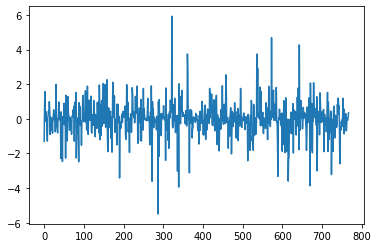

In [87]:
plt.plot(feat[0,2].detach().numpy())
plt.show()